# Recreate the ixnos model in this notebook
Make a pytorch model w the same architecture and try to load in the pickled weights and biases
into that model. Then, find sensible outputs

In [26]:
import torch
from torch import nn

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [27]:
class iXnos(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(760, 200),
            nn.Tanh(),
            nn.Linear(200, 1),
            nn.ReLU(),
        )
    
    def forward(self, x):
        # x = self.flatten(x)
        output = self.layers(x)
        return output 


model = iXnos().to(device)
print(model)
for key, value in model.state_dict().items():
    print(key, value.shape)

iXnos(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=760, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=1, bias=True)
    (3): ReLU()
  )
)
layers.0.weight torch.Size([200, 760])
layers.0.bias torch.Size([200])
layers.2.weight torch.Size([1, 200])
layers.2.bias torch.Size([1])


In [28]:
import pickle
# pklpath = "iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch70/codon_scores.pkl"
pklpath = "iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch70/weights.pkl"
# Open the file in read-binary mode
with open(pklpath, 'rb') as file:
    # Load the pickled data
    data = pickle.load(file, encoding='bytes')

# data#.shape
len(data)
for idx, val in enumerate(data):
    data[idx] = torch.from_numpy(val).T
    print(data[idx].shape)

torch.Size([200, 760])
torch.Size([200])
torch.Size([1, 200])
torch.Size([1])


(0.0, 5.0016597492073425)

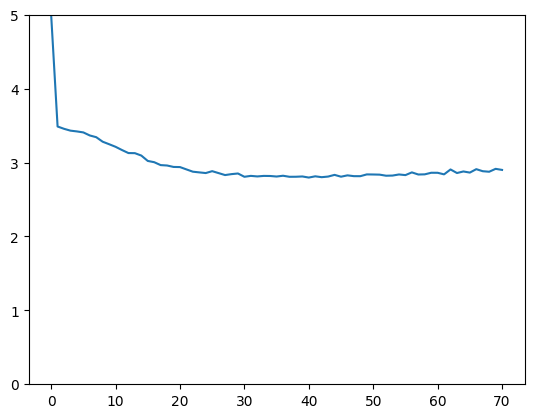

In [161]:
costs = "iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch70/te_cost_by_epoch.pkl"
with open(costs, 'rb') as file:
    costs = pickle.load(file, encoding='bytes')


plt.plot(range(len(costs)), costs)
plt.ylim(0, max(costs))
# costs

In [29]:
from collections import OrderedDict
dummy = "layers"
labels = [f"{dummy}.0.weight", f"{dummy}.0.bias", f"{dummy}.2.weight", f"{dummy}.2.bias"]

old_model = OrderedDict(zip(labels, data))

model.load_state_dict(old_model)
print(model)

iXnos(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=760, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=1, bias=True)
    (3): ReLU()
  )
)


In [122]:
null = torch.zeros(760)
indices = torch.randint(0, 760, (40,))
null[indices] = 1
model(null)

tensor([0.], grad_fn=<ReluBackward0>)

## Try to get data

In [31]:
# TODO: add a larger sequence class that checks that everything is valid and
# makes decisions about truncating ends of the overall sequence before formatting
# it to be fed into the model. Tbh this is a placeholder class for now
class Footprint():
    def __init__(self, sequence):
        self.sequence = sequence
        self.codons = self.get_codons()

    def get_codons(self):
        return [self.sequence[i:i+3] for i in range(0, len(self.sequence), 3)]
    

f = Footprint("GCAGCAGCA")
f.codons

['GCA', 'GCA', 'GCA']

In [32]:
[f.codons[i] == "GCA" for i in range(len(f.codons))]

[True, True, True]

In [ ]:
alpha="ACGT"
nts = ["A", "C", "G", "T"]
codons = [x+y+z for x in alpha for y in alpha for z in alpha]
cod2id = {codon:idx for idx, codon in enumerate(codons)}
id2cod = {idx:codon for codon, idx in cod2id.items()}
nt2id = {nt:idx for idx, nt in enumerate(alpha)}
id2nt = {idx:nt for nt, idx in nt2id.items()}

`/mnt/lareaulab/shelen/clean_vestigium` has helen's stuff



In [35]:
# import pandas as pd
# pd.read_csv("iXnos/expts/iwasaki/process/outputs.size.27.30.txt", sep="\t")

with open("iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/init_data/y_te.pkl", "rb") as file:
    y_te = pickle.load(file, encoding='bytes')
with open("iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/init_data/y_tr.pkl", "rb") as file:
    y_tr = pickle.load(file, encoding='bytes')
# with open("iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/init_data/init_data.pkl", "rb") as file:
#     X = pickle.load(file, encoding='bytes')

# X = {key.decode('utf-8'): value for key, value in X.items()}

print(y_te.shape)
print(y_tr.shape)
# print(X.keys())
# # print(X['rel_struc_idxs'])
# print(X['rel_nt_idxs'])
# print(X['rel_cod_idxs'])
# for key, value in X.items():
#     print(key, ": ", value)

(49134, 1)
(98898, 1)


In [37]:
import numpy as np
import pandas as pd
# NOTE: This file appears to contain the training data, so codons -> scaled counts
fname = "iXnos/expts/iwasaki/process/tr_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt"

# fname = "iXnos/expts/iwasaki/process/te_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt"
# NOTE: looks like they start with the 20th codon, and likely that they end 20 codons early here
df = pd.read_csv(fname, sep='\t')
# NOTE: I won't be able to use this for the first ~5 codons bc I don't know what the preceding codons / nts are, but it's OK for now. 
genes_truncated = df.groupby("gene")["cod_seq"].agg(''.join) # We'll need this for nt features. 

nt_idx = np.arange(-15, 15)
cod_idx = np.arange(-5, 5)

In [126]:
te = df.iloc[11]
gene = te["gene"]
# TODO: get codon indices

print(te)
def codon_1he(codon_index:int, codons=codons): # Should be a class thing so I don't need to sus input codons
    arr = np.zeros(64)
    arr[codons.index(codon_index)] = 1
    return arr

n5p4 = cod_idx + te["cod_idx"]
# print(gene[te["cod_idx"] - 2: te["cod_idx"] + 1])
# assert gene[te["cod_idx"]] == te['cod_seq']
codon_vector = []
for cod in n5p4: 
    codon_vector.append(codon_1he(df.loc[(df['gene'] == gene) & (df['cod_idx'] == cod), "cod_seq"].item()))
codon_vector = np.concatenate(codon_vector)
# TODO: get nt indices (which nt in the A site is 0??)

gene          ENST00000022615.7
cod_idx                      31
cod_seq                     AAA
raw_cts                     8.0
scaled_cts             1.390828
Name: 11, dtype: object


In [127]:
def nt_1he(nt, nts=nts): # Should be a class thing so I don't need to sus input nts
    arr = np.zeros(4)
    arr[nts.index(nt)] = 1
    return arr


footprint_nt = "".join(df.loc[(df['gene'] == gene) & (df['cod_idx'].isin(n5p4)), "cod_seq"].tolist())

nt_vector = []
for i in footprint_nt:
    nt_vector.append(nt_1he(i))
nt_vector = np.concatenate(nt_vector)

In [128]:
input = np.concatenate([codon_vector, nt_vector])
# input = np.concatenate([nt_vector, codon_vector])
input = torch.from_numpy(input).to(torch.float32)
model(input).item()


2.7380576133728027

### Read in some fasta file
It'd be ideal to get a df of the entire CDS of a given gene in addition to the dataframe 
that contains the actual scaled counts, and I think this `.fa` file mibht be it. But it looks like I might have to manually get the CDS from that (codons in the counts file are 'out of frame')? 

In [99]:
from Bio import SeqIO

fasta_f = "iXnos/genome_data/human.transcripts.13cds10.transcripts.fa"

records = list(SeqIO.parse(fasta_f, "fasta"))
genes = pd.DataFrame({
        'ID': [record.id for record in records],
        'seq': [str(record.seq) for record in records]
    }).set_index("ID")

In [147]:
seq = genes.loc["ENST00000022615.7", "seq"]
cs = [seq[i:i+3] for i in range(0, len(seq), 3)]
len(seq)

875

In [157]:
genes_truncated["ENST00000022615.7"]
seq.split(genes_truncated["ENST00000022615.7"])

['ATTTTTCTAAGATATGTGTAACACACCAACGTACTGTGACCTAGGAAAGGCTGCTAAGGATGTCTTCAACAAA',
 'GGGAAGAACTTCAGTGCAGGAGGTCACAAGGTTGGCTTGGGATTTGAACTGGAAGCTTAATGTGGTTTGA']

# Weinberg?

In [ ]:
import sys
import os
sys.path.append("src")
from model import load_ixnos
from src import *

weinberg_dir = "/mnt/lareaulab/rtunney/iXnos/expts/weinberg"
model_dir = f"{weinberg_dir}/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch60"
model_w = load_ixnos(
    f"{model_dir}/weights.pkl")
ydf = pd.read_csv(
    f"{weinberg_dir}/process/tr_set_bounds.size.27.31.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep='\t')

Using cpu device


In [ ]:
def encode(idx, arr):
    output = np.zeros(len(arr))
    output[arr.index(idx)] = 1
    return output

In [ ]:
def encode(val, arr):
    # Given an array of potential values (arr) and a value (val), 
    # return a 1-hot-encoded numpy array of that value
    # e.g. encode(A ,[A, T, G, C]) -> [1, 0, 0, 0]
    output = np.zeros(len(arr))
    output[arr.index(val)] = 1
    return output

def predict(i, model, df):
    # Given index i in a y dataframe (df), apply model to predict
    # scaled count for the codon at that index. 
    y = df.iloc[i]
    gene = y["gene"]
    # TODO: get codon indices
    n5p4 = cod_idx + y["cod_idx"]
    codon_vector = []
    for cod in n5p4: 
        df_codon_idx = df.loc[
            (df['gene'] == gene) & 
            (df['cod_idx'] == cod), "cod_seq"].item()
        codon_vector.append(
            encode(
                df_codon_idx,
                codons))
    codon_vector = np.concatenate(codon_vector)

    footprint_nt = "".join(df.loc[(df['gene'] == gene) & (df['cod_idx'].isin(n5p4)), "cod_seq"].tolist())

    nt_vector = []
    for i in footprint_nt:
        nt_vector.append(encode(i, nts))
    nt_vector = np.concatenate(nt_vector)
    input = np.concatenate([codon_vector, nt_vector])
    # input = np.concatenate([nt_vector, codon_vector])
    input = torch.from_numpy(input).to(torch.float32)
    return model(input).item(), y["scaled_cts"].item()

def pred_gene(gene, ydf, model):
    # Predict scaled counts for all codons in a gene
    # NOTE: currently excludes first and last 5 codons bc truncated 
    ydf_gene = ydf[ydf["gene"] == gene]
    gene_len = len(ydf_gene) # How many codons
    pred, actual = [], []

    for i in range(gene_len):
        codon_index = ydf_gene.iloc[i]["cod_idx"]
        if i > 5 and i < gene_len - 5:
            p, t = predict(i, model, ydf_gene)
            pred.append(p)
            actual.append(t)
    return pred, actual

def plot_counts(pred, actual, ax=None):
    # Plot predicted and actual scaled counts along 
    # a gene.
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(
        range(len(pred)), pred, label="Prediction"
    )
    ax.plot(
        range(len(actual)), actual, label="Actual"
    )
    ax.set_ylabel("Scaled Counts")
    ax.set_xlabel("Codon")
    ax.legend(**legend_kwargs())
    return ax

In [249]:
pred, actual = pred_gene(ydf["gene"].unique()[0], ydf, model_w)
pred2, actual2 = pred_gene(ydf["gene"].unique()[1], ydf, model_w)

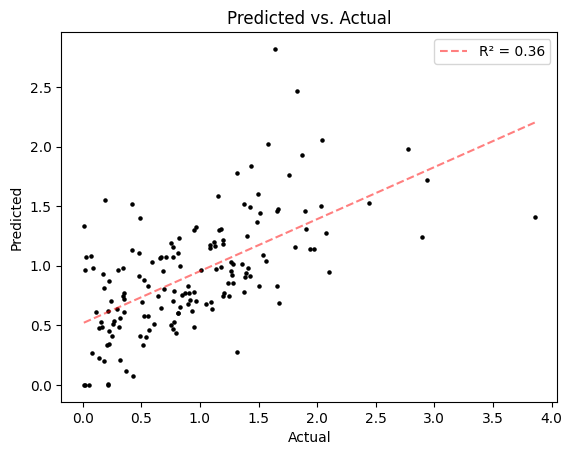

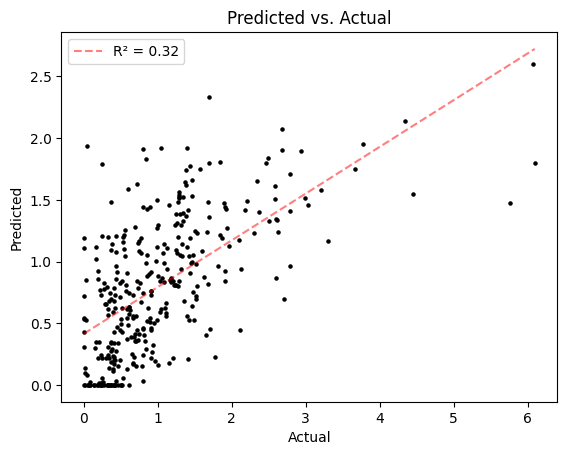

In [250]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_pred(pred, actual):
    plt.scatter(actual, pred, s=5, c='k')
    slope, intercept = np.polyfit(actual, pred, 1)
    # Generate values for the line of best fit
    fit_line = slope * np.array(actual) + intercept

    # Plot the line of best fit
    plt.plot(
        sorted(actual), sorted(fit_line), 
        color='r', linestyle="--", alpha=0.5,
        label=f'R² = {r2_score(actual, pred):.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs. Actual')
    plt.legend()
    plt.show()

plot_pred(pred, actual)
plot_pred(pred2, actual2)


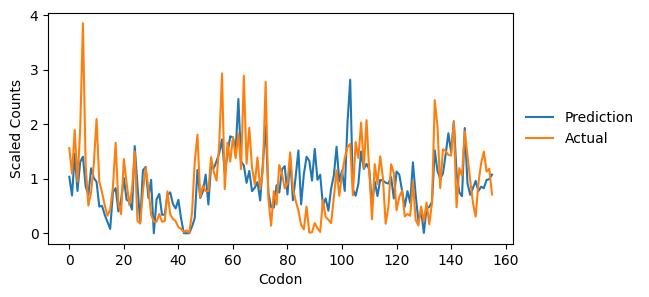

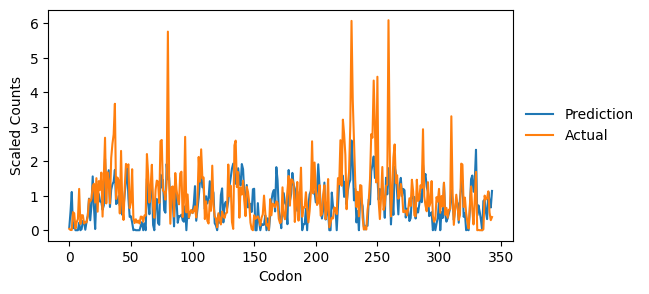

In [266]:
plot_counts(pred, actual)
plt.show()
plot_counts(pred2, actual2)
plt.show()